In [3]:
def nums_visualisation(df,annotation=False):
    '''
    визуализация распределений количественных признаков: 
        - гисторгамма распределения 
        - boxplot распределения
    '''
    columns = df.columns
    cols_num = df.shape[1]

    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: 
        print(('Всего признаков этого типа {}.\nК ним относятся: ' + fstr).
              format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) /min_diff + 1),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()
    
def num_visualisation(column,df, left_sloping=False):
    '''
    Визулизация распределения количественного ризнака:
        - гистограмма распределения в валидационной и в полной обучающей выборке 
        - boxplot распределения в валидационной и в полной обучающей выборке
        - гистограмма распределения  в валидационной выборке и в обучающей выборке на марках, 
        встречающихся в валидационной выборке
        - boxplot рапсределения в валидационной выборке и в обучающей выборке на марках, 
        встречающихся в валидационной выборке
    '''
    trn = df[df['sample']==1]
    tst = df[df['sample']==0]
    tst_brands = tst.brand.unique()
    brand_mask = [x in tst_brands for x in trn.brand]
    trn_ = trn[brand_mask]   
    
    row_trn = trn[column] 
    row_tst = tst[column] 
    row_trn_ = trn_[column]     

    if left_sloping: 
        row_trn = np.log(2022 - row_trn)
        row_tst = np.log(2022 - row_tst)
        row_trn_ = np.log(2022 - row_trn_)        
    else:
        row_trn = np.log(row_trn+1)
        row_tst = np.log(row_tst+1)
        row_trn_ = np.log(row_trn_+1)
    
    fig = plt.figure(figsize=(14,4))
#*******************************************************************
    ax1 = fig.add_axes([0, 0.4, 0.45, 1])
    plt.title('Распределение '+column+' в train (на всех марках) и в test' )
    row_trn.plot.kde(alpha = 0.65) 
    row_tst.plot.kde(alpha = 0.65)    
#     row_trn.plot.hist(bins=50,density=True,alpha = 0.65)
#     row_tst.plot.hist(bins=50,density=True,alpha = 0.65)
    plt.legend(['train','test']) 
#*******************************************************************
    ax2 = fig.add_axes([0, 0, 0.45, 0.30]) 
    sns.boxplot(data = [row_trn,row_tst],orient='h',saturation = 0.5)
#*******************************************************************
    ax3 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение '+column+' в train (только на марках из test) и в test' )
    row_trn_.plot.hist(bins=50,density=True,alpha = 0.65)
    row_tst.plot.hist(bins=50,density=True,alpha = 0.65)
    plt.legend(['train','test']) 
#*******************************************************************
    ax4 = fig.add_axes([0.55, 0, 0.45, 0.30]) 
    sns.boxplot(data = [row_trn_,row_tst],orient='h',saturation = 0.5)
    plt.show() 
    
def features_price_scatterplot(column):
    fig, ax = plt.subplots(1,len(most_popular_brands), figsize=(16, 6))
    for i,brand in enumerate(most_popular_brands):
        tmp = data[data.brand==brand]
        ax[i].scatter(x = tmp[column], y = tmp.offerprice, alpha=0.3)
        ax[i].set_title('для автмобилей марки ' + brand)
        ax[i].set_xlabel(column)
        ax[i].set_ylabel("offerprice")
        ax[i].set_yscale( "log")
    plt.show()

def features_price_scatterplot(df,stud_column,top_column, n_top):
    top = df[top_column].value_counts().index[:n_top]    
    fig, ax = plt.subplots(1,len(top), figsize=(20, 4))

    for i,cat_val in enumerate(top):
        tmp = df[df[top_column]==cat_val]
        ax[i].scatter(x = tmp[stud_column], y = tmp.price, alpha=0.3)
        ax[i].set_title('для '+ top_column + ' ' + cat_val)
        ax[i].set_xlabel(stud_column)
        ax[i].set_ylabel("price")
        ax[i].set_yscale( "log")
        ax[i].set_xlim(left=max(x.min(),0),right = x.max())
        
    plt.show()

## Импорт бибилиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import date

import warnings

# %pylab 
%matplotlib inline

from project_7_functions import *

## Установка параметров и определение констант

In [5]:
from project_7_constants import *

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 70)    # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

##  Загрузка даных

In [6]:
df_kaggle = pd.read_csv(f'{path}auto_ru_2020_09_09.csv',low_memory=False)
df_kaggle_full = pd.read_csv(f'{path}all_auto_ru_09_09_2020.csv',low_memory=False)

test = pd.read_csv(f'{path}test.csv',low_memory=False)

In [7]:
# test.columns

## Приведение к единому виду

In [8]:
%%time 
externdata_test = externdata_test_unification(test)
# externdata_train = externdata_train_unification(df_kaggle)
externdata_train_full = externdata_train_unification(df_kaggle_full)

Wall time: 4min 38s


## Объединение test и train

In [9]:
# externdata_train['sample'] = 1  # помечаем где у нас трейн
externdata_train_full['sample'] = 1  # помечаем где у нас трейн
externdata_test['sample'] = 0   # помечаем где у нас тест
externdata_test['price'] = np.NaN  # в тесте нет значения price -  пока просто заполняем np.NaN
# объединяем
# externdata = externdata_test.append(externdata_train, sort=False).reset_index(drop=True) 
externdata_full = externdata_test.append(externdata_train_full, sort=False).reset_index(drop=True) 

## EDA
Разделим признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols`.   
К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.  
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 27 а также очевидно категориальные название модели и марку автомобиля.   
Порогом для количественного признака будет наличие более чем 27 уникальных значений. При этом учитываем, что название модели и марку автомобиля из количественных признаков мы исключили.  


In [10]:
# Посмотри обьекты какого типа находятся теперь в колонках датасета.
externdata_full.apply(lambda x: type(x.iloc[0]))

bodyType                         <class 'str'>
brand                            <class 'str'>
color                            <class 'str'>
engineDisplacement     <class 'numpy.float64'>
enginePower              <class 'numpy.int64'>
equipment_dict                  <class 'list'>
fuelType                         <class 'str'>
mileage                  <class 'numpy.int64'>
modelDate                <class 'numpy.int64'>
model_name                       <class 'str'>
numberOfDoors            <class 'numpy.int64'>
productionDate           <class 'numpy.int64'>
vehicleTransmission              <class 'str'>
vendor                           <class 'str'>
Владельцы              <class 'numpy.float64'>
Владение                 <class 'numpy.int64'>
ПТС                              <class 'str'>
Привод                           <class 'str'>
Руль                             <class 'str'>
sample                   <class 'numpy.int64'>
price                  <class 'numpy.float64'>
dtype: object

Всё прилично, кроме `equipment_dict`, котрый содержит list опций. На этом этапе приведем этот признак к количеству опций. 

In [11]:
externdata_full.equipment_dict = externdata_full.equipment_dict.apply(len)

Определяем кличество уникальных знчений в каждой колонке и относим признак к соответсвующему типу данных (преобразвание `astype(str)` необходимо для избежания `TypeError: ("unhashable type: 'list'", 'occurred at index equipment_dict')`)

In [12]:
num_uniq = externdata_full.apply(lambda x: x.astype(str).nunique())
num_uniq

bodyType                  25
brand                     36
color                     16
engineDisplacement        69
enginePower              398
equipment_dict           114
fuelType                   5
mileage                24379
modelDate                 78
model_name              1104
numberOfDoors              5
productionDate            80
vehicleTransmission        4
vendor                     3
Владельцы                  4
Владение                 307
ПТС                        3
Привод                     3
Руль                       2
sample                     2
price                   8169
dtype: int64

In [13]:
bin_cols = externdata_full.columns[num_uniq==2].drop('sample')
cat_cols = externdata_full.columns[(num_uniq>2) & (num_uniq<28)].append(pd.Index(['model_name','brand'])) 
num_cols = externdata_full.columns[num_uniq>=28].drop(['model_name','brand','price'])

Рассмотрим признаки по типам
### Количественные
Ознакомимся с распределением всех признаков (гистограмма и boxplot на всем dataset)

Всего признаков этого типа 7.
К ним относятся: engineDisplacement, enginePower, equipment_dict, mileage, modelDate, productionDate, Владение


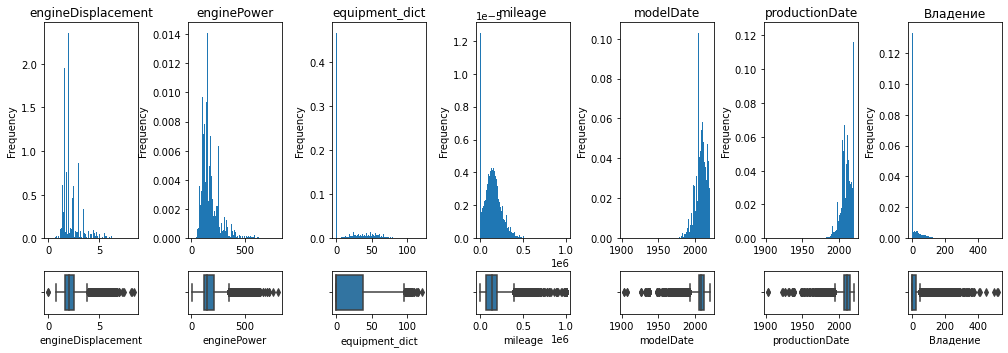

In [14]:
nums_visualisation(externdata_full[num_cols],annotation=True)

Как видим все количественные признаки имеют скошенное распределение:
- **engineDisplacement**, **enginePower**, **equipment_dict**,**mileage** и **Владение** скошены вправо;
- **modelDate**, **productionDate** скошены влево.   
    
Если бы мы испопльзовали модели, чувствтельные к ненормальности распределения признаков, следовало провести преобразование, например логарфимрование и наверное стандартизацию. Но я собираюсь использовать модели, строящий градиентный бустинг над деревьями. этот класс алгоритвмов нечувствителен к ненормальнотис, поэтому преобразование проводит не имеет смысла. Ну мы и не будем.
    
Попробуем выявить заисимости между числовыми признаками, для этого постоим pairplot и посчитаем матрицу корреляций Спирмена (диаганальные 1-цы уберем, чтобы не мешали).

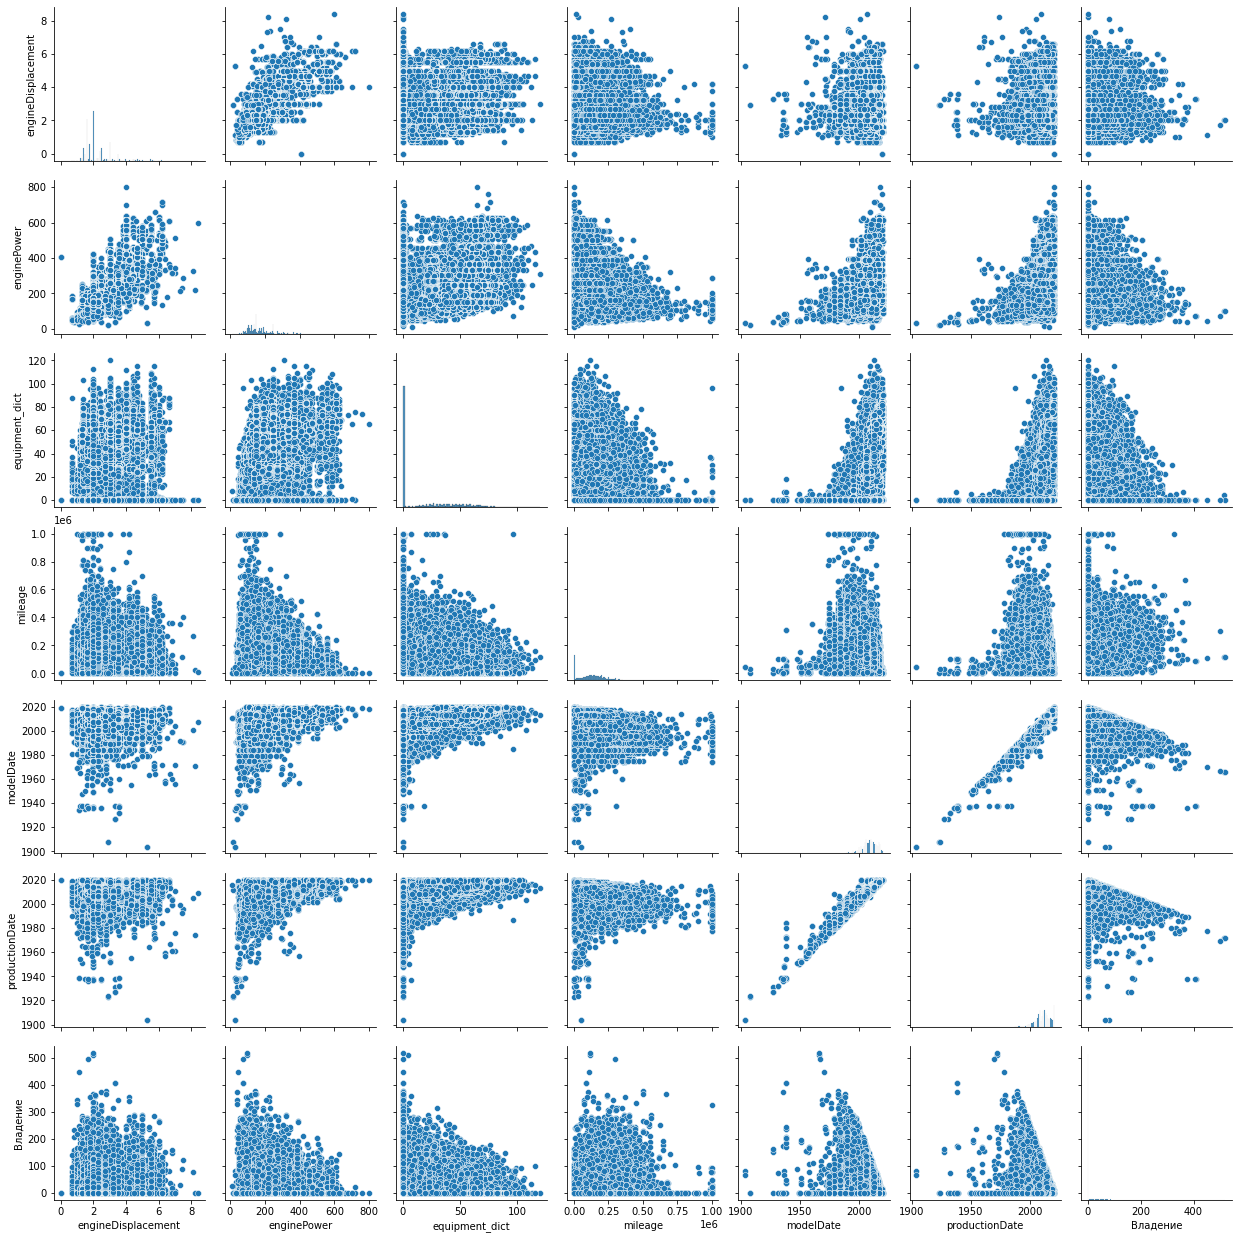

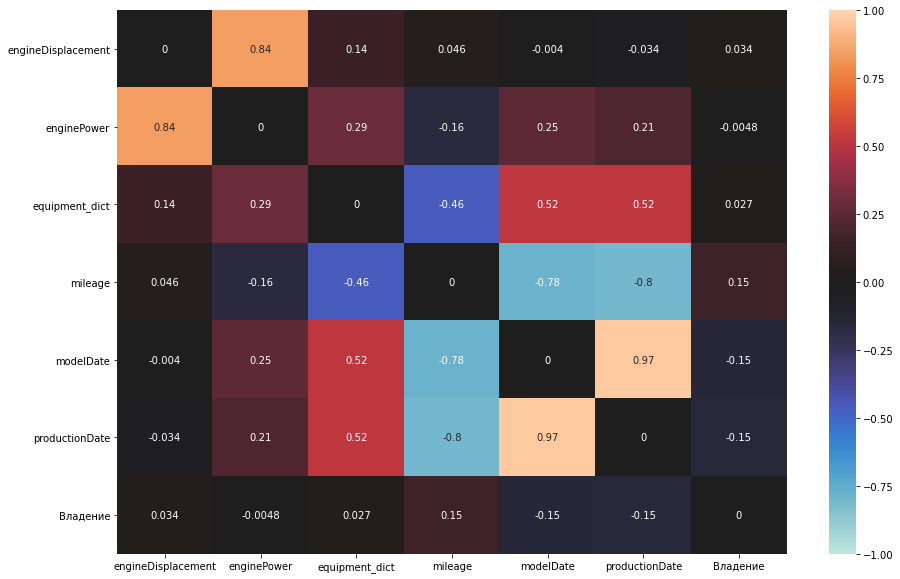

In [15]:
sns.pairplot(externdata_full[num_cols]);
corr_matrix = externdata_full[num_cols].corr(method='spearman')-np.eye(len(num_cols))
plt.figure(figsize = (15,10))
sns.heatmap(corr_matrix, annot = True,vmin=-1, vmax=1, center= 0);

Стоит отметить наличие заметных коррялици в нескольких парах признаков.   
    
Некоторые из корреляций обьясняются причинно-следственной связью признаков, например у таких как `engineDisplacement-enginePower`, `modelDate-productionDate`, `productionDate-mileage` - мощность двигателя зависит от его обьема, дата выпуска машины естественно связана с датой начала производства данной модели, а пробег в общем пропорционален возрасту автомобиля (т.е. связан с датой производства).    
    
Некоторые корреляции можно впролне обьяснить пользуясь здравым смыслом и жизненным опытом. Например 
`modelDate-enginePower`, `productionDate-enginePower` и `modelDate-equipment_dict` - в общем с течением времени мощность двигателей у новых моделей росла, также расла оснащенность автомобилей различными опциями.   
    
Некотрые корреляции не отражают какойлибо причинн-следственной связи и обьясняются зависимостью обех признаков от третьего. Напрмер в парах `equipment_dict-enginePower` и `equipment_dict-mileage` оба признака зависят от даты выпуска авто.   
    
Сделанные выводы о зависимостях помогут на этапе создания новых призгакв. Напрмер можно попробовать заменить один из сильно коррелированных `modelDate` и `productionDate` на разницу между ними, получив таким образом вполне осмысленный признак ***новизна модели***

Посмотрим на pairplot-ы, на корреляции Спирмена количественных признаков и целевой переменной.

,engineDisplacement,enginePower,equipment_dict,mileage,modelDate,productionDate,Владение
price,0.447695,0.660069,0.57651,-0.687421,0.794383,0.788078,-0.119163


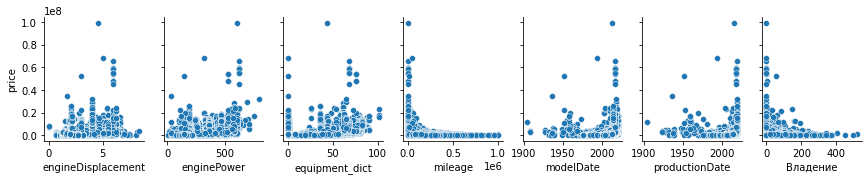

In [16]:
sns.pairplot(externdata_full[list(num_cols) + ['price']],
             x_vars=list(num_cols) , #+ ['price']
             y_vars=['price'],
             aspect=0.7)
externdata_full[['price'] + list(num_cols)].corr(method='spearman').loc[['price'],:][num_cols]

In [17]:
externdata_full[['price'] + list(num_cols)].corr(method='spearman').loc[['price'],:][num_cols]

,engineDisplacement,enginePower,equipment_dict,mileage,modelDate,productionDate,Владение
price,0.447695,0.660069,0.57651,-0.687421,0.794383,0.788078,-0.119163


Как видиим ... .... ..   
.... ..   
.... ..   
.... ..

### Детальное изучение
Теперь рассмотрим каждый признак отдельно, а именно 
- постоим график и box-plot признака на test и всем train, 
- график и box-plot признака на test и на данных train для марок встречающтхся в test.    
визуально сравним распределения.  
- затем построим зависимость целевой переменной от признака для трех самых популярных марок.

Получим три наиболее часто встречающиеся в data марки и модели:

In [18]:
def features_price_scatterplot(df,stud_column,top_column, n_top):
    top = df[top_column].value_counts().index[:n_top]    
    fig, ax = plt.subplots(1,len(top), figsize=(20, 4))

    for i,cat_val in enumerate(top):
        tmp = df[df[top_column]==cat_val]
        x = tmp[stud_column]
        y = tmp.price
        ax[i].scatter(x = x, y = y, alpha=0.3)
        ax[i].set_title('для '+ top_column + ' ' + str(cat_val))
        ax[i].set_xlabel(stud_column)
        ax[i].set_ylabel("price")
        ax[i].set_yscale( "log")
        xmarg = 0.1*(x.max() - max(x.min(),0))
        ax[i].set_xlim(left=max(x.min(),0)-xmarg,right = x.max()+xmarg)
#         ax[i].set_xmargin(0.2)
    plt.show(x.max())

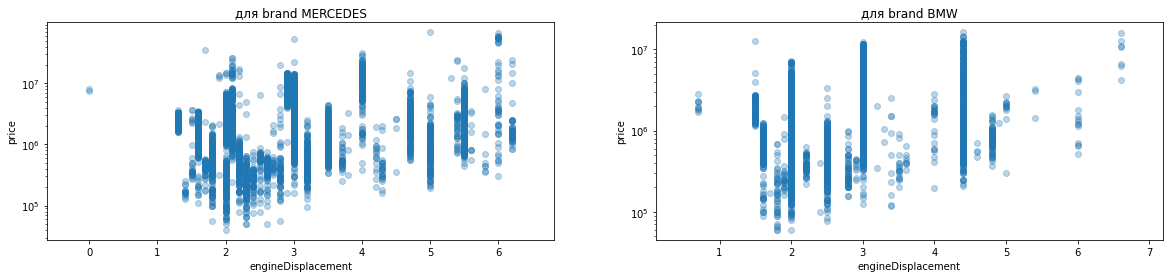

In [19]:
features_price_scatterplot(externdata_full,'engineDisplacement','brand',2)

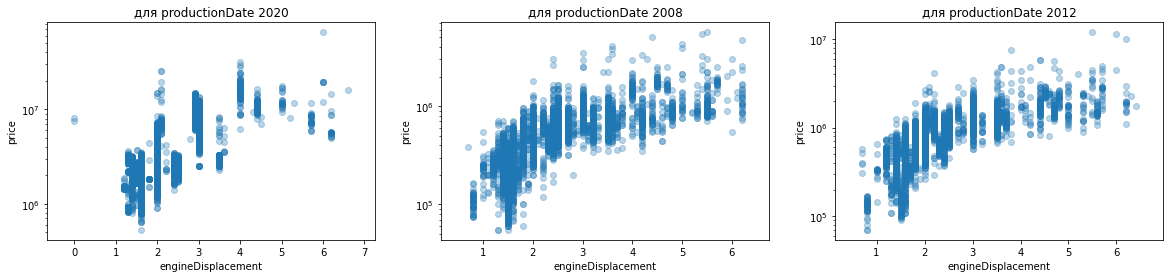

In [20]:
features_price_scatterplot(externdata_full,'engineDisplacement','productionDate',3)

In [21]:
externdata_train_full.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'price', 'equipment_dict', 'model_name', 'vendor', 'sample'],
      dtype='object')

Приступим к изучению признаков
### engineDisplacement
признак описывает обьем двигателя. 

In [42]:
def num_visualisation(column,df, left_sloping=False):
    '''
    Визулизация распределения количественного ризнака:
        - гистограмма распределения в валидационной и в полной обучающей выборке 
        - boxplot распределения в валидационной и в полной обучающей выборке
        - гистограмма распределения  в валидационной выборке и в обучающей выборке на марках, 
        встречающихся в валидационной выборке
        - boxplot рапсределения в валидационной выборке и в обучающей выборке на марках, 
        встречающихся в валидационной выборке
    '''
    trn = df[df['sample']==1]
    tst = df[df['sample']==0]
    tst_brands = tst.brand.unique()
    brand_mask = [x in tst_brands for x in trn.brand]
    trn_ = trn[brand_mask]   
    
    row_trn = trn[column] 
    row_tst = tst[column] 
    row_trn_ = trn_[column]     

    if left_sloping: 
        row_trn = np.log(2022 - row_trn)
        row_tst = np.log(2022 - row_tst)
        row_trn_ = np.log(2022 - row_trn_)        
    else:
        row_trn = np.log(row_trn+1)
        row_tst = np.log(row_tst+1)
        row_trn_ = np.log(row_trn_+1)
    
    fig = plt.figure(figsize=(14,3))
    
    nbins = 50
    rows_max = max(row_trn.max(),row_tst.max())
    rows_min = min(row_trn.min(),row_tst.min())    
    step = (rows_max-rows_min)/nbins
    bins = list(np.arange(rows_min,rows_max,step))
#*******************************************************************
    ax1 = fig.add_axes([0, 0.4, 0.3, 1])
    plt.title('Распределение '+column+' в train\n (на всех марках) и в test' )
    row_trn.plot.hist(bins=bins,density=True,alpha = 0.65)
    row_tst.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['train','test']) 
#*******************************************************************
    ax2 = fig.add_axes([0, 0, 0.3, 0.30]) 
    sns.boxplot(data = [row_trn,row_tst],orient='h',saturation = 0.5)
#*******************************************************************
    ax3 = fig.add_axes([0.35, 0.4, 0.30, 1])
    plt.title('Распределение '+column+' в train\n (только на марках из test) и в test' )
    row_trn_.plot.hist(bins=bins,density=True,alpha = 0.65)
    row_tst.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['train','test']) 
#*******************************************************************
    ax4 = fig.add_axes([0.35, 0, 0.30, 0.30]) 
    sns.boxplot(data = [row_trn_,row_tst],orient='h',saturation = 0.5)
#*******************************************************************
    ax5 = fig.add_axes([0.7, 0, 0.30, 1.4])
    plt.title('Зависимость цены\n от '+column+' в logscale')
    x = row_trn.sample(frac = 0.25)
    y = trn.price[x.index]
    
    ax5.set_yscale('log') #     ax5.scatter(x = x, y = y, alpha=0.3)

    sns.kdeplot(x = x, y = y) # , fill=True

    plt.show() 

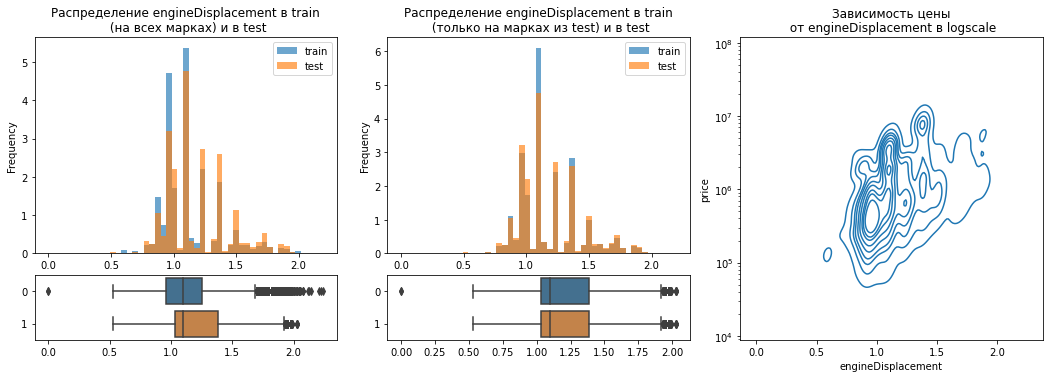

Wall time: 21.6 s


In [43]:
%%time
num_visualisation('engineDisplacement',externdata_full)

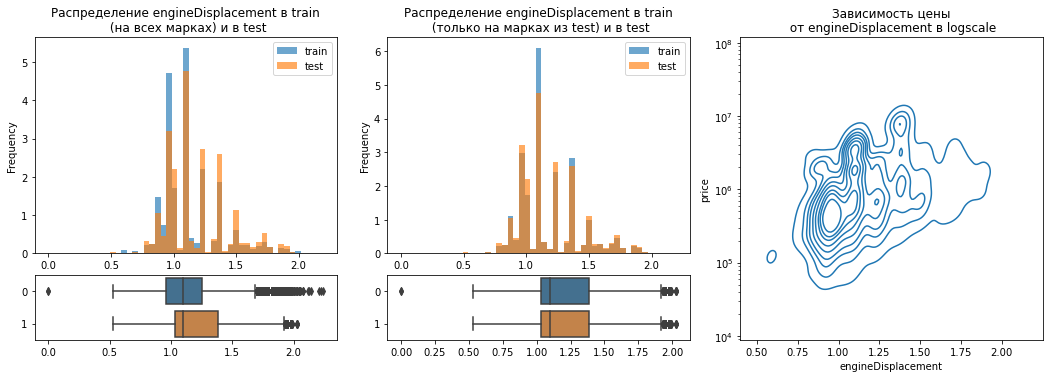

Wall time: 17 s


In [44]:
%%time
num_visualisation('engineDisplacement',externdata_full)

### категориальные

In [12]:
cat_cols

Index(['bodyType', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission',
       'vendor', 'Владельцы', 'ПТС', 'Привод', 'model_name', 'brand'],
      dtype='object')

### бинарные

In [13]:
bin_cols

Index(['Руль'], dtype='object')

In [ ]:
cat_cols = data.columns[(num_uniq>2) & (num_uniq<28)].append(pd.Index(['model_name','brand'])) 

In [ ]:
num_cols = data.columns[num_uniq>=28].drop(time_col).drop(['model_name','brand','price'])

# ============================

%%html
<html>
<body>
<table>
        <tr> 
            <th>Name</th> 
            <th>Country</th> 
            <th>Age</th> 
        </tr> 
        <tr> 
            <td>Sid</td> 
            <td>India</td> 
            <td>22</td> 
        </tr>
        <tr> 
            <td>Dave</td> 
            <td>UK</td> 
            <td>28</td> 
        </tr>
</table>
</body>
</html>

In [ ]:
%lsmagic

In [ ]:
%time?

In [ ]:
%%timeit
1

In [ ]:
def features_price_scatterplot(df,column,):
    fig, ax = plt.subplots(1,len(most_popular_brands), figsize=(16, 6))
    for i,brand in enumerate(most_popular_brands):
        tmp = df[df.brand==brand]
        ax[i].scatter(x = tmp[column], y = tmp.price, alpha=0.3)
        ax[i].set_title('для автмобилей марки ' + brand)
        ax[i].set_xlabel(column)
        ax[i].set_ylabel("price")
        ax[i].set_yscale( "log")
    plt.show()

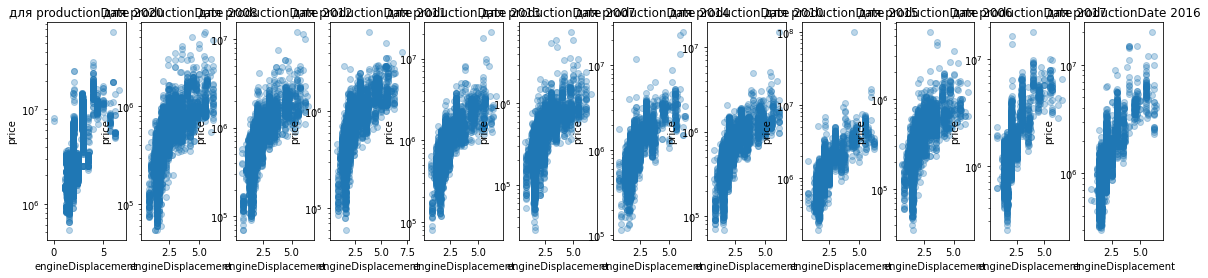

In [40]:
features_price_scatterplot(externdata_full,'engineDisplacement','productionDate',12)

In [ ]:
# Поскольку в дальнейшем мы, вероятно, будем среди прочих использовать модели чувствительные к сильно ненормальному распределению признака, то применим к признакам преобразование (`log(x+1)` для скошенных вправо и `log(2022-x)` для сошеных влево).  
# Посмотрим на результат:

# to_log = ['engineDisplacement', 'enginePower', 'equipment_dict','mileage','Владение']
# to_minus_log = ['modelDate', 'productionDate']
# externdata_full[to_log] = np.log(externdata_full[to_log]+1)
# externdata_full[to_minus_log] = np.log(2022 - externdata_full[to_minus_log])

In [ ]:
# Картина улучшилась -  распределения либо стали близки к нормальному, либо скошенность 
# существенно уменьшилась. Далее будем работать спризнаком с учетом преобразования.

# nums_visualisation(np.log(externdata_full[[
#     'engineDisplacement', 'enginePower', 'equipment_dict','mileage','Владение']]+1))

# nums_visualisation(np.log(2022 - externdata_full[['modelDate', 'productionDate']]))